


# Create and run a local RAG pipeline from scratch

The goal of this notebook is to build a RAG (Retrieval Augmented Generation) pipeline from scratch.

Specifically, we'd like to be able to open a PDF file, ask questions (queries) of it and have them answered by a Large Language Model (LLM).


## What is RAG?

RAG stands for Retrieval Augmented Generation.


Each step can be roughly broken down to:

* **Retrieval** - This step involves finding useful information from a source based on a question or query. For example, it could mean searching for relevant passages of text from a database like Wikipedia in response to a question.
* **Augmented** -  In this step, the retrieved information is used to enhance or modify the input given to a generative model. For instance, the relevant passages retrieved in the previous step are used to adjust the input provided to a language generation model (such as an LLM).
* **Generation** - Finally, in the generation step, the modified input is used by the generative model to produce an output. For example, using the adjusted input from the previous step, the generative model generates a response or passage of text.

## Why RAG?

The main goal of RAG is to improve the generation outptus of LLMs.

Two primary improvements can be seen as:
1. **Preventing hallucinations** -LLMs can make mistakes and generate incorrect information. RAG pipelines can help make LLMs more accurate by giving them factual information as input. Even if the answer from a RAG pipeline seems wrong, you can check the sources it used to generate that answer. This helps ensure the information is reliable
2. **Work with custom data** - Many base LLMs are trained with internet-scale text data. This means they have a great ability to model language, however, they often lack specific knowledge. RAG systems can provide LLMs with domain-specific data such as medical information or company documentation and thus customized their outputs to suit specific use cases.


RAG can also be a much quicker solution to implement than fine-tuning an LLM on specific data.



## What kind of problems can RAG be used for?

RAG can help anywhere there is a specific set of information that an LLM may not have in its training data ( anything not publicly accessible on the internet).

For example you could use RAG for:
* **Customer support Q&A chat**
* **Email chain analysis** -
* **Company internal documentation chat** -
* **Textbook(course support) Q&A**

Klarna, a large financial company, [uses a system like this](https://www.klarna.com/international/press/klarna-ai-assistant-handles-two-thirds-of-customer-service-chats-in-its-first-month/) to save $40M per year on customer support costs.




## Key terms

| Term | Description |
| ----- | ----- |
| **Token** | A sub-word piece of text. For example, "hello, world!" could be split into ["hello", ",", "world", "!"]. A token can be a whole word,<br> part of a word or group of punctuation characters. 1 token ~= 4 characters in English, 100 tokens ~= 75 words.<br> Text gets broken into tokens before being passed to an LLM. |
| **Embedding** | A learned numerical representation of a piece of data. For example, a sentence of text could be represented by a vector with<br> 768 values. Similar pieces of text (in meaning) will ideally have similar values. |
| **Embedding model** | A model designed to accept input data and output a numerical representation. For example, a text embedding model may take in 384 <br>tokens of text and turn it into a vector of size 768. |
| **Similarity search/vector search** | Similarity search/vector search aims to find two vectors which are close together in high-demensional space. For example, <br>two pieces of similar text passed through an embedding model should have a high similarity score.<br> Different topics will have a lower similarity score. Common similarity score measures are dot product and cosine similarity. |
| **Large Language Model (LLM)** | A model which has been trained to numerically represent the patterns in text. A generative LLM will continue a sequence when given a sequence. <br>For example, given a sequence of the text "hello, world!", a genertive LLM may produce "we're going to build a RAG pipeline today!".<br> This generation will be highly dependant on the training data and prompt. |
| **LLM context window** | The number of tokens a LLM can accept as input. For example, as of March 2024, GPT-4 has a default context window of 32k tokens<br> (about 96 pages of text) but can go up to 128k if needed. A recent open-source LLM from Google, Gemma (March 2024) has a context<br> window of 8,192 tokens (about 24 pages of text). A higher context window means an LLM can accept more relevant information<br> to assist with a query. For example, in a RAG pipeline, if a model has a larger context window, it can accept more reference items<br> from the retrieval system to aid with its generation. |
| **Prompt** | A common term for describing the input to a generative LLM. The idea of "[prompt engineering](https://en.wikipedia.org/wiki/Prompt_engineering)" is to structure a text-based<br> (or potentially image-based as well) input to a generative LLM in a specific way so that the generated output is ideal. This technique is<br> possible because of a LLMs capacity for in-context learning, as in, it is able to use its representation of language to breakdown <br>the prompt and recognize what a suitable output may be (note: the output of LLMs is probable, so terms like "may output" are used). |




 ## What we're going to build

We're going to build RAG pipeline which enables us to chat with a PDF document, specifically an open-source [Scrum Guides 2020](https://scrumguides.org/docs/scrumguide/v2020/2020-Scrum-Guide-US.pdf), ~14 pages long.

You could call our project NutriChat!

We'll write the code to:
1. Open a PDF document (you could use another PDF).
2. Format the text of the PDF textbook ready for an embedding model (this process is known as text splitting/chunking).
3. Embed all of the chunks of text in the textbook and turn them into numerical representation which we can store for later.
4. Build a retrieval system that uses vector search to find relevant chunks of text based on a query.
5. Create a prompt that incorporates the retrieved pieces of text.
6. Generate an answer to a query based on passages from the textbook.




this Structure is  similar to the workflow outlined on the NVIDIA blog which [details a local RAG pipeline](https://developer.nvidia.com/blog/rag-101-demystifying-retrieval-augmented-generation-pipelines/).

<img src="https://github.com/mrdbourke/simple-local-rag/blob/main/images/simple-local-rag-workflow-flowchart.png?raw=true" alt="flowchart of a local RAG workflow" />

In [ ]:

!pip install -U torch # requires torch 2.1.1+ (for efficient sdpa implementation)
!pip install PyMuPDF # for reading PDFs with Python
!pip install tqdm # for progress bars
!pip install sentence-transformers # for embedding models
!pip install accelerate # for quantization model loading
!pip install bitsandbytes # for quantizing models (less storage space)
!pip install flash-attn --no-build-isolation # for faster attention mechanism = faster LLM inference

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 MB 3.8 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 2.2.0
    Uninstalling triton-2.2.0:
      Successfully uninstalled triton-2.2.0
  Attempting uninstall: nvidia-nccl-cu12
    Found existing installation: nvidia-nccl-cu12 2.19.3
    Uninstalling nvidia-nccl-cu12-2.19.3:
      Successfully uninstalled nvidia-nccl-cu12-2.19.3
  Attempting uninstall: torch
    Found existing installation: torch 2.2.1+cu121
    Uninstalling torch-2.2.1+cu121:
      Successfully uninstalled torch-2.2.1+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.2.1+cu121 requires torch==2.2.1, but you have torch 2

## 1. Document/Text Processing and Embedding Creation

Ingredients:
* PDF document of choice.
* Embedding model of choice.

Steps:
1. Import PDF document.
2. Process text for embedding (e.g. split into chunks of sentences).
3. Embed text chunks with embedding model.
4. Save embeddings to file for later use (embeddings will store on file for many years or until you lose your hard drive).

In [ ]:
# Download PDF file
import os
import requests

# Get PDF document
pdf_path = "ScrumGuides2020.pdf"

# Download PDF if it doesn't already exist
if not os.path.exists(pdf_path):
  print("File doesn't exist, downloading...")

  # The URL of the PDF you want to download
  url = "https://scrumguides.org/docs/scrumguide/v2020/2020-Scrum-Guide-US.pdf"

  # The local filename to save the downloaded file
  filename = pdf_path

  # Send a GET request to the URL
  response = requests.get(url)

  # Check if the request was successful
  if response.status_code == 200:
      # Open a file in binary write mode and save the content to it
      with open(filename, "wb") as file:
          file.write(response.content)
      print(f"The file has been downloaded and saved as {filename}")
  else:
      print(f"Failed to download the file. Status code: {response.status_code}")
else:
  print(f"File {pdf_path} exists.")

File ScrumGuides2020.pdf exists.


PDF acquired!

We can import the pages of our PDF to text by first defining the PDF path and then opening and reading it with PyMuPDF

We'll write a small helper function to preprocess the text.

We'll save each page to a dictionary and then append that dictionary to a list for ease of use later.

In [ ]:
import fitz
from tqdm.auto import tqdm # for progress bars, requires !pip install tqdm

def text_formatter(text: str) -> str:
    """Performs minor formatting on text."""
    cleaned_text = text.replace("\n", " ").strip() # note: this might be different for each doc (best to experiment)

    return cleaned_text


def open_and_read_pdf(pdf_path: str) -> list[dict]:
    """
    Opens a PDF file, reads its text content page by page, and collects statistics.

    Parameters:
        pdf_path (str): The file path to the PDF document to be opened and read.

    Returns:
        list[dict]: A list of dictionaries, each containing the page number
        (adjusted), character count, word count, sentence count, token count, and the extracted text
        for each page.
    """
    doc = fitz.open(pdf_path)  # open a document
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):  # iterate the document pages
        text = page.get_text()  # get plain text encoded as UTF-8
        text = text_formatter(text)
        pages_and_texts.append({"page_number": page_number - 3,  # adjust page numbers since our PDF starts on page 3
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4,  # 1 token = ~4 chars, see: https://help.openai.com/en/articles/4936856-what-are-tokens-and-how-to-count-them
                                "text": text})
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[:2]

0it [00:00, ?it/s]

[{'page_number': -3,
  'page_char_count': 170,
  'page_word_count': 77,
  'page_sentence_count_raw': 1,
  'page_token_count': 42.5,
  'text': 'Ken Schwaber & Jeff Sutherland                      The Scrum Guide    The Definitive Guide to Scrum: The Rules of the Game                                  November 2020'},
 {'page_number': -2,
  'page_char_count': 2059,
  'page_word_count': 372,
  'page_sentence_count_raw': 17,
  'page_token_count': 514.75,
  'text': '1  Purpose of the Scrum Guide  We developed Scrum in the early 1990s. We wrote the first version of the Scrum Guide in 2010 to help  people worldwide understand Scrum.  We have evolved the Guide since then through small, functional  updates. Together, we stand behind it.     The Scrum Guide contains the definition of Scrum. Each element of the framework serves a specific  purpose that is essential to the overall value and results realized with Scrum. Changing the core design  or ideas of Scrum, leaving out elements, or not follow

Now let's get a random sample of the pages.

In [ ]:
import random

random.sample(pages_and_texts, k=3)

[{'page_number': 2,
  'page_char_count': 2350,
  'page_word_count': 410,
  'page_sentence_count_raw': 20,
  'page_token_count': 587.5,
  'text': '5  Scrum Team  The fundamental unit of Scrum is a small team of people, a Scrum Team. The Scrum Team consists of  one Scrum Master, one Product Owner, and Developers. Within a Scrum Team, there are no sub-teams  or hierarchies. It is a cohesive unit of professionals focused on one objective at a time, the Product Goal.    Scrum Teams are cross-functional, meaning the members have all the skills necessary to create value  each Sprint. They are also self-managing, meaning they internally decide who does what, when, and  how.    The Scrum Team is small enough to remain nimble and large enough to complete significant work within  a Sprint, typically 10 or fewer people. In general, we have found that smaller teams communicate better  and are more productive. If Scrum Teams become too large, they should consider reorganizing into  multiple cohesive

### Get some stats on the text

Let's perform a rough exploratory data analysis (EDA) to get an idea of the size of the texts (e.g. character counts, word counts etc) we're working with.

The different sizes of texts will be a good indicator into how we should split our texts.

Many embedding models have limits on the size of texts they can ingest, for example, the [`sentence-transformers`](https://www.sbert.net/docs/pretrained_models.html) model [`all-mpnet-base-v2`](https://huggingface.co/sentence-transformers/all-mpnet-base-v2) has an input size of 384 tokens.

This means that the model has been trained in ingest and turn into embeddings texts with 384 tokens (1 token ~= 4 characters ~= 0.75 words).

Texts over 384 tokens which are encoded by this model will be auotmatically reduced to 384 tokens in length, potentially losing some information.
''

For now, let's turn our list of dictionaries into a DataFrame and explore it.

In [ ]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-3,170,77,1,42.50,Ken Schwaber & Jeff Sutherland ...
1,-2,2059,372,17,514.75,1 Purpose of the Scrum Guide We developed Sc...
2,-1,4432,177,29,1108.00,2 Purpose of the Scrum Guide ................
3,0,2262,391,26,565.50,3 Scrum Definition Scrum is a lightweight fr...
4,1,2119,367,20,529.75,4 Transparency enables inspection. Inspecti...


In [ ]:
# Get stats
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,14.00,14.00,14.00,14.00,14.00
mean,3.50,2149.93,343.14,18.93,537.48
std,4.18,869.50,101.83,6.92,217.37
min,-3.00,170.00,77.00,1.00,42.50
25%,0.25,2011.00,342.00,15.25,502.75
50%,3.50,2189.50,378.50,20.00,547.38
75%,6.75,2328.00,399.50,23.75,582.00
max,10.00,4432.00,438.00,29.00,1108.00


Okay, looks like our average token count per page is 537.48.

For this particular use case, it means we can't embed an average whole page with the `all-mpnet-base-v2` model (this model has an input capacity of 384).

### Further text processing (splitting pages into sentences)

A simple method I've found helpful is to break the text into chunks of sentences.

As in, chunk a page of text into groups of 5, 7, 10 or more sentences (these values are not set in stone and can be explored).

But we want to follow the workflow of:

`Ingest text -> split it into groups/chunks -> embed the groups/chunks -> use the embeddings`

Some options for splitting text into sentences:

1. Split into sentences with simple rules (e.g. split on ". " with `text = text.split(". ")`, like we did above).
2. Split into sentences with a natural language processing (NLP) library such as [spaCy](https://spacy.io/) or [nltk](https://www.nltk.org/).

Why split into sentences?

* Easier to handle than larger pages of text (especially if pages are densely filled with text).
* Can get specific and find out which group of sentences were used to help within a RAG pipeline.



In [ ]:
from spacy.lang.en import English

nlp = English()

# Add a sentencizer pipeline,
nlp.add_pipe("sentencizer")

# Create a document instance as an example
doc = nlp("This is a sentence. This another sentence.")
assert len(list(doc.sents)) == 2

# Access the sentences of the document
list(doc.sents)

[This is a sentence., This another sentence.]

In [ ]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)

    # Make sure all sentences are strings
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]

    # Count the sentences
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/14 [00:00<?, ?it/s]

In [ ]:
# Inspect an example
random.sample(pages_and_texts, k=1)

[{'page_number': 1,
  'page_char_count': 2119,
  'page_word_count': 367,
  'page_sentence_count_raw': 20,
  'page_token_count': 529.75,
  'text': '4    Transparency enables inspection. Inspection without transparency is misleading and wasteful.  Inspection  The Scrum artifacts and the progress toward agreed goals must be inspected frequently and diligently to  detect potentially undesirable variances or problems. To help with inspection, Scrum provides cadence  in the form of its five events.     Inspection enables adaptation. Inspection without adaptation is considered pointless. Scrum events are  designed to provoke change.  Adaptation  If any aspects of a process deviate outside acceptable limits or if the resulting product is unacceptable,  the process being applied or the materials being produced must be adjusted. The adjustment must be  made as soon as possible to minimize further deviation.     Adaptation becomes more difficult when the people involved are not empowered or self-

Wonderful!

Now let's turn out list of dictionaries into a DataFrame and get some stats.

In [ ]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,14.00,14.00,14.00,14.00,14.00,14.00
mean,3.50,2149.93,343.14,18.93,537.48,17.00
std,4.18,869.50,101.83,6.92,217.37,8.03
min,-3.00,170.00,77.00,1.00,42.50,1.00
25%,0.25,2011.00,342.00,15.25,502.75,14.25
50%,3.50,2189.50,378.50,20.00,547.38,18.00
75%,6.75,2328.00,399.50,23.75,582.00,23.00
max,10.00,4432.00,438.00,29.00,1108.00,26.00


Now we've got our text split into sentences, how about we gorup those sentences?

### Chunking our sentences together

Let's take a step to break down our list of sentences/text into smaller chunks.

As you might've guessed, this process is referred to as **chunking**.

Why do we do this?

1. Easier to manage similar sized chunks of text.
2. Don't overload the embedding models capacity for tokens (e.g. if an embedding model has a capacity of 384 tokens, there could be information loss if you try to embed a sequence of 400+ tokens).

Something to note is that there are many different ways emerging for creating chunks of information/text.

For now, we're going to keep it simple and break our pages of sentences into groups of 10 (this number is arbitrary and can be changed, I just picked it because it seemed to line up well with our embedding model capacity of 384).

On average each of our pages has 17 sentences.

And an average total of 537.48 tokens per page.

So our groups of 10 sentences will also be ~287 tokens long.

This gives us plenty of room for the text to embedded by our `all-mpnet-base-v2` model (it has a capacity of 384 tokens).

To split our groups of sentences into chunks of 10 or less, let's create a function which accepts a list as input and recursively breaks into down into sublists of a specified size.

In [ ]:
# Define split size to turn groups of sentences into chunks
num_sentence_chunk_size = 10

# Create a function that recursively splits a list into desired sizes
def split_list(input_list: list,
               slice_size: int) -> list[list[str]]:
    """
    Splits the input_list into sublists of size slice_size (or as close as possible).

    For example, a list of 17 sentences would be split into two lists of [[10], [7]]
    """
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

# Loop through pages and texts and split sentences into chunks
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/14 [00:00<?, ?it/s]

In [ ]:
# Sample an example from the group (note: many samples have only 1 chunk as they have <=10 sentences total)
random.sample(pages_and_texts, k=1)

[{'page_number': 10,
  'page_char_count': 1995,
  'page_word_count': 340,
  'page_sentence_count_raw': 15,
  'page_token_count': 498.75,
  'text': '13  End Note  Scrum is free and offered in this Guide. The Scrum framework, as outlined herein, is immutable. While  implementing only parts of Scrum is possible, the result is not Scrum. Scrum exists only in its entirety  and functions well as a container for other techniques, methodologies, and practices.  Acknowledgements  People   Of the thousands of people who have contributed to Scrum, we should single out those who were  instrumental at the start: Jeff Sutherland worked with Jeff McKenna and John Scumniotales, and Ken  Schwaber worked with Mike Smith and Chris Martin, and all of them worked together. Many others  contributed in the ensuing years and without their help Scrum would not be refined as it is today.  Scrum Guide History  Ken Schwaber and Jeff Sutherland first co-presented Scrum at the OOPSLA Conference in 1995. It  essenti

In [ ]:
# Create a DataFrame to get stats
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,14.00,14.00,14.00,14.00,14.00,14.00,14.00
mean,3.50,2149.93,343.14,18.93,537.48,17.00,2.14
std,4.18,869.50,101.83,6.92,217.37,8.03,0.66
min,-3.00,170.00,77.00,1.00,42.50,1.00,1.00
25%,0.25,2011.00,342.00,15.25,502.75,14.25,2.00
50%,3.50,2189.50,378.50,20.00,547.38,18.00,2.00
75%,6.75,2328.00,399.50,23.75,582.00,23.00,2.75
max,10.00,4432.00,438.00,29.00,1108.00,26.00,3.00


Note how the average number of chunks is around 2.14.

### Splitting each chunk into its own item

We'd like to embed each chunk of sentences into its own numerical representation.

So to keep things clean, let's create a new list of dictionaries each containing a single chunk of sentences with relative information such as page number as well statistics about each chunk.

In [ ]:
import re

# Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]

        # Join the sentences together into a paragraph-like structure, aka a chunk (so they are a single string)
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" -> ". A" for any full-stop/capital letter combo
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get stats about the chunk
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 characters

        pages_and_chunks.append(chunk_dict)

# How many chunks do we have?
len(pages_and_chunks)

  0%|          | 0/14 [00:00<?, ?it/s]

30

In [ ]:
# View a random sample
random.sample(pages_and_chunks, k=1)

[{'page_number': 4,
  'sentence_chunk': '7 ● Helping find techniques for effective Product Goal definition and Product Backlog management; ● Helping the Scrum Team understand the need for clear and concise Product Backlog items; ● Helping establish empirical product planning for a complex environment; and, ● Facilitating stakeholder collaboration as requested or needed.  The Scrum Master serves the organization in several ways, including:   ● Leading, training, and coaching the organization in its Scrum adoption; ● Planning and advising Scrum implementations within the organization;  ● Helping employees and stakeholders understand and enact an empirical approach for complex work; and, ● Removing barriers between stakeholders and Scrum Teams. Scrum Events The Sprint is a container for all other events. Each event in Scrum is a formal opportunity to inspect and adapt Scrum artifacts. These events are specifically designed to enable the transparency required. Failure to operate any events

Now we've broken our whole textbook into chunks of 10 sentences or less as well as the page number they came from.

This means we could reference a chunk of text and know its source.

Let's get some stats about our chunks.

In [ ]:
# Get stats about our chunks
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,30.00,30.00,30.00,30.00
mean,4.07,984.23,141.60,246.06
std,3.85,697.54,43.69,174.39
min,-3.00,140.00,47.00,35.00
25%,1.00,734.25,113.25,183.56
50%,4.50,883.00,137.00,220.75
75%,7.00,1084.25,171.25,271.06
max,10.00,4368.00,216.00,1092.00


How about we check for samples with less than 100 tokens and see if they are worth keeping?

In [ ]:
# Show random chunks with under 30 tokens in length
min_token_length = 100
for row in df[df["chunk_token_count"] <= min_token_length].sample().iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 35.0 | Text: Ken Schwaber & Jeff Sutherland           The Scrum Guide  The Definitive Guide to Scrum: The Rules of the Game                 November 2020




They don't seem to offer too much information.

Let's filter our DataFrame/list of dictionaries to only include chunks with over 100 tokens in length.

In [ ]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -2,
  'sentence_chunk': '1 Purpose of the Scrum Guide We developed Scrum in the early 1990s. We wrote the first version of the Scrum Guide in 2010 to help people worldwide understand Scrum. We have evolved the Guide since then through small, functional updates. Together, we stand behind it.  The Scrum Guide contains the definition of Scrum. Each element of the framework serves a specific purpose that is essential to the overall value and results realized with Scrum. Changing the core design or ideas of Scrum, leaving out elements, or not following the rules of Scrum, covers up problems and limits the benefits of Scrum, potentially even rendering it useless.  We follow the growing use of Scrum within an ever-growing complex world. We are humbled to see Scrum being adopted in many domains holding essentially complex work, beyond software product development where Scrum has its roots. As Scrum’s use spreads, developers, researchers, analysts, scientists, and other special

### Embedding our text chunks

While humans understand text, machines understand numbers best.

An embedding is "a useful numerical representation".

Modern embeddings are powerful because they're learned representations. Instead of just assigning numbers to words or characters, they learn from large amounts of text to understand how words relate to each other. This means that similar texts have similar numerical representations, which helps capture their meaning.

Our goal is to turn each of our chunks into a numerical representation (an embedding vector, where a vector is a sequence of numbers arranged in order).



To do so, we'll use the [`sentence-transformers`](https://www.sbert.net/docs/installation.html) library which contains many pre-trained embedding models.

Specifically, we'll get the `all-mpnet-base-v2` model (you can see the model's intended use on the [Hugging Face model card](https://huggingface.co/sentence-transformers/all-mpnet-base-v2#intended-uses)).

In [ ]:
# Requires !pip install sentence-transformers
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device="cpu") # choose the device to load the model to (note: GPU will often be *much* faster than CPU)

# Create a list of sentences to turn into numbers
sentences = [
    "This is Text 1.",
    "This is Text 2"
]

# Sentences are encoded/embedded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# See the embeddings
for sentence, embedding in embeddings_dict.items():
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print(f"Embedding size: {embedding.shape}")
    print("")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Sentence: This is Text 1.
Embedding: [ 9.75295715e-03 -7.39128515e-02 -1.00256680e-02  1.43767279e-02
 -4.85379957e-02  2.15252209e-02  5.33135645e-02  4.41174619e-02
 -7.03035109e-03 -4.89920937e-02  6.25495166e-02 -4.98305224e-02
  4.69006635e-02  9.75257345e-03  9.60413553e-03 -4.87291776e-02
  2.51518413e-02  2.30907393e-03 -2.41744462e-02  2.70246677e-02
  2.92923320e-02  5.00636399e-02 -1.54664954e-02  1.53235886e-02
  2.89669093e-02  1.55073591e-02  1.37315914e-02 -1.04551446e-02
 -1.34987514e-02 -5.94648570e-02 -1.42172235e-03  4.33686599e-02
  3.08130123e-02 -4.10750434e-02  1.77144386e-06 -1.02486403e-04
 -1.81298722e-02  1.16295470e-02 -2.62386352e-02 -3.21995355e-02
 -3.23741394e-03  3.01694572e-02  1.40995458e-02  3.32522504e-02
 -8.25466774e-03  5.02678528e-02  2.56829504e-02  7.57182837e-02
 -2.92755850e-03  5.61592504e-02 -1.07232863e-02 -8.56487527e-02
 -3.06986854e-04  1.65975036e-03  1.34024173e-01 -8.23819195e-04
  1.15009723e-03 -3.59355891e-03  1.60480104e-02  1.2

We've now got a way to numerically represent each of our chunks.

Our embedding has a shape of `(768,)`.

> **Note:** No matter the size of the text input to our `all-mpnet-base-v2` model, it will be turned into an embedding size of `(768,)`. This value is fixed. So whether a sentence is 1 token long or 1000 tokens long, it will be truncated/padded with zeros to size 384 and then turned into an embedding vector of size `(768,)`. Of course, other embedding models may have different input/output shapes.







We can perform batched operations by turning our target text samples into a single list and then passing that list to our embedding model.

In [ ]:
%%time

# Send the model to the GPU
embedding_model.to("cuda") # requires a GPU installed, for reference on my local machine, I'm using a NVIDIA RTX 4090

# Create embeddings one by one on the GPU
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])


  0%|          | 0/29 [00:00<?, ?it/s]

CPU times: user 1.95 s, sys: 269 ms, total: 2.22 s
Wall time: 5.92 s


In [ ]:
# Turn text chunks into a single list
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]

In [ ]:
%%time

# Embed all texts in batches
text_chunk_embeddings = embedding_model.encode(text_chunks,
                                               batch_size=32, # you can use different batch sizes.
                                               convert_to_tensor=True) # optional to return embeddings as tensor instead of array

text_chunk_embeddings

CPU times: user 519 ms, sys: 5.53 ms, total: 524 ms
Wall time: 790 ms


tensor([[ 0.0429, -0.0455, -0.0390,  ..., -0.0047,  0.0244, -0.0321],
        [ 0.0222,  0.0139, -0.0465,  ...,  0.0267,  0.0285, -0.0154],
        [ 0.0050, -0.0570, -0.0208,  ...,  0.0201, -0.0470, -0.0300],
        ...,
        [-0.0345,  0.0242,  0.0151,  ...,  0.0351,  0.0262,  0.0025],
        [ 0.0284, -0.0301, -0.0429,  ..., -0.0002, -0.0007, -0.0204],
        [ 0.0246,  0.0115, -0.0339,  ...,  0.0263,  0.0055, -0.0261]],
       device='cuda:0')

### Save embeddings to file

Since creating embeddings can be a timely process (not so much for our case but it can be for more larger datasets), let's turn our `pages_and_chunks_over_min_token_len` list of dictionaries into a DataFrame and save it.

In [ ]:
# Save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_Scrum_Guide_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

And we can make sure it imports nicely by loading it.

In [ ]:
# Import saved file and view
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-2,1 Purpose of the Scrum Guide We developed Scru...,975,159,243.75,[ 4.28953134e-02 -4.54633683e-02 -3.89775634e-...
1,-2,We use the word “developers” in Scrum not to e...,1037,167,259.25,[ 2.22419314e-02 1.39400745e-02 -4.64514494e-...
2,-1,2 Purpose of the Scrum Guide ...................,4368,113,1092.00,[ 4.97504463e-03 -5.70194125e-02 -2.07776222e-...
3,0,3 Scrum Definition Scrum is a lightweight fram...,640,114,160.00,[-3.97593118e-02 -7.89307579e-02 -4.50061820e-...
4,0,The Scrum framework is purposefully incomplete...,905,132,226.25,[-3.95166082e-03 -3.09048705e-02 -7.36358901e-...
5,0,Scrum engages groups of people who collectivel...,677,107,169.25,[-2.27453057e-02 -1.70536917e-02 -2.53405217e-...
6,1,4 Transparency enables inspection. Inspection...,845,123,211.25,[-2.35201661e-02 2.19518435e-03 -1.82819031e-...
7,1,A Scrum Team is expected to adapt the moment i...,1239,210,309.75,[-2.33201892e-03 -1.79955568e-02 -2.26278789e-...
8,2,5 Scrum Team The fundamental unit of Scrum is ...,976,162,244.00,[-9.53231566e-03 -5.96922487e-02 -1.94336791e-...
9,2,The Scrum Team is responsible for all product-...,1333,208,333.25,[ 2.01637708e-02 -2.97048893e-02 -2.60758176e-...


## 2. RAG - Search and Answer

RAG stands for Retrieval Augmented Generation.

Which is another way of saying "given a query, search for relevant resources and answer based on those resources".

The whole idea of RAG is to get an LLM to be more factually correct based on your own input as well as have a reference to where the generated output may have come from.



### Similarity search

Similarity search, also known as semantic search or vector search, is like searching for things based on their "vibe" or "meaning".

Imagine you're searching for a song, but instead of typing in the song title, you describe the vibe or feeling you're looking for. For example, you might say, "I want a song that feels upbeat and energetic like 'Happy' by Pharrell Williams."

Similarly, in similarity search, you're not just searching for exact matches of words. Instead, you're searching for items (like documents, images, or products) that have a similar meaning to what you're looking for.

So, instead of searching for specific words or phrases, you're searching for things that have a similar overall meaning to your query. This can be really useful for finding related content or items that might not have the exact keywords you're searching for.


In [ ]:
import random

import torch
import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# Import texts and embedding df
text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_Scrum_Guide_df.csv")

# Convert embedding column back to np.array (it got converted to string when it got saved to CSV)
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

# Convert embeddings to torch tensor and send to device (note: NumPy arrays are float64, torch tensors are float32 by default)
embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape

torch.Size([29, 768])

In [ ]:
text_chunks_and_embedding_df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-2,1 Purpose of the Scrum Guide We developed Scru...,975,159,243.75,"[0.0428953134, -0.0454633683, -0.0389775634, -..."
1,-2,We use the word “developers” in Scrum not to e...,1037,167,259.25,"[0.0222419314, 0.0139400745, -0.0464514494, -0..."
2,-1,2 Purpose of the Scrum Guide ...................,4368,113,1092.00,"[0.00497504463, -0.0570194125, -0.0207776222, ..."
3,0,3 Scrum Definition Scrum is a lightweight fram...,640,114,160.00,"[-0.0397593118, -0.0789307579, -0.0045006182, ..."
4,0,The Scrum framework is purposefully incomplete...,905,132,226.25,"[-0.00395166082, -0.0309048705, -0.00736358901..."


In [ ]:
embeddings[0]

tensor([ 4.2895e-02, -4.5463e-02, -3.8978e-02, -5.0630e-02, -2.6787e-02,
        -8.4307e-04,  4.4579e-04, -5.2299e-02, -5.1140e-02, -1.6031e-02,
         7.9100e-02,  3.9966e-02,  2.1147e-03,  7.9024e-02, -2.7723e-02,
        -6.6029e-02,  1.9616e-02, -1.5142e-02, -3.2519e-02,  3.4478e-02,
         4.0790e-02, -2.0528e-02, -4.4841e-02,  3.1467e-02, -2.4672e-02,
        -1.8382e-02, -8.1641e-03,  7.5024e-02, -6.4283e-02, -2.0768e-02,
        -9.1134e-04, -6.7989e-04,  3.6131e-02, -4.3953e-02,  2.5085e-06,
        -3.8412e-02, -3.1339e-02, -2.5598e-03, -2.0005e-02,  4.6250e-02,
         1.0044e-02,  2.6568e-02, -1.4316e-02,  2.7246e-02,  3.0501e-02,
         5.8463e-02,  1.1862e-02,  9.3522e-02,  6.4617e-03,  2.6171e-02,
        -9.3403e-03, -2.3680e-02, -5.3468e-02, -3.2255e-02, -5.4742e-02,
        -5.8089e-02, -4.7875e-02,  1.9093e-02,  1.9270e-02,  1.2150e-02,
         7.1236e-03,  1.5189e-02,  7.9086e-03, -1.4239e-02,  4.4044e-02,
         5.0021e-02, -2.8407e-03, -5.4176e-02, -9.7

In [ ]:
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device=device) # choose the device to load the model to



perform a semantic search.

Let's say you weres earching the scrum definition.

And wanted to search your textbook for "macronutrients functions".

Well, we can do so with the following steps:
1. Define a query string (e.g. `"scrum definition"`)
2. Turn the query string in an embedding with same model we used to embed our text chunks.
3. Perform a [dot product](https://pytorch.org/docs/stable/generated/torch.dot.html) or [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) function between the text embeddings and the query embedding (we'll get to what these are shortly) to get similarity scores.
4. Sort the results from step 3 in descending order (a higher score means more similarity in the eyes of the model) and use these values to inspect the texts.



In [ ]:
# 1. Define the query
query = "scrum definition"
print(f"Query: {query}")

# 2. Embed the query to the same numerical space as the text examples
# Note: It's important to embed your query with the same model you embedded your examples with.
query_embedding = embedding_model.encode(query, convert_to_tensor=True)

# 3. Get similarity scores with the dot product (we'll time this for fun)
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

# 4. Get the top-k results (we'll keep this to 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: scrum definition
Time take to get scores on 29 embeddings: 0.01062 seconds.


torch.return_types.topk(
values=tensor([0.8193, 0.6639, 0.6222, 0.6094, 0.6039], device='cuda:0'),
indices=tensor([ 3,  8,  4, 28,  5], device='cuda:0'))

In [ ]:
larger_embeddings = torch.randn(100*embeddings.shape[0], 768).to(device)
print(f"Embeddings shape: {larger_embeddings.shape}")

# Perform dot product across 168,000 embeddings
start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=larger_embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(larger_embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

Embeddings shape: torch.Size([2900, 768])
Time take to get scores on 2900 embeddings: 0.02564 seconds.


Let's check the results of our original similarity search.


In [ ]:
# Define helper function to print wrapped text
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

Now we can loop through the `top_results_dot_product` tuple and match up the scores and indicies and then use those indicies to index on our `pages_and_chunks` variable to get the relevant text chunk.


In [ ]:
print(f"Query: '{query}'\n")
print("Results:")
# Loop through zipped together scores and indicies from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    # Print the page number too so we can reference the textbook further (and check the results)
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'scrum definition'

Results:
Score: 0.8193
Text:
3 Scrum Definition Scrum is a lightweight framework that helps people, teams and
organizations generate value through adaptive solutions for complex problems.
In a nutshell, Scrum requires a Scrum Master to foster an environment where:
1. A Product Owner orders the work for a complex problem into a Product Backlog.
2. The Scrum Team turns a selection of the work into an Increment of value
during a Sprint. 3. The Scrum Team and its stakeholders inspect the results and
adjust for the next Sprint. 4. Repeat   Scrum is simple. Try it as is and
determine if its philosophy, theory, and structure help to achieve goals and
create value.
Page number: 0


Score: 0.6639
Text:
5 Scrum Team The fundamental unit of Scrum is a small team of people, a Scrum
Team. The Scrum Team consists of one Scrum Master, one Product Owner, and
Developers. Within a Scrum Team, there are no sub-teams or hierarchies. It is a
cohesive unit of professionals focused



We get a very relevant answer to our query `"scrum definition"` even though its quite vague.

T

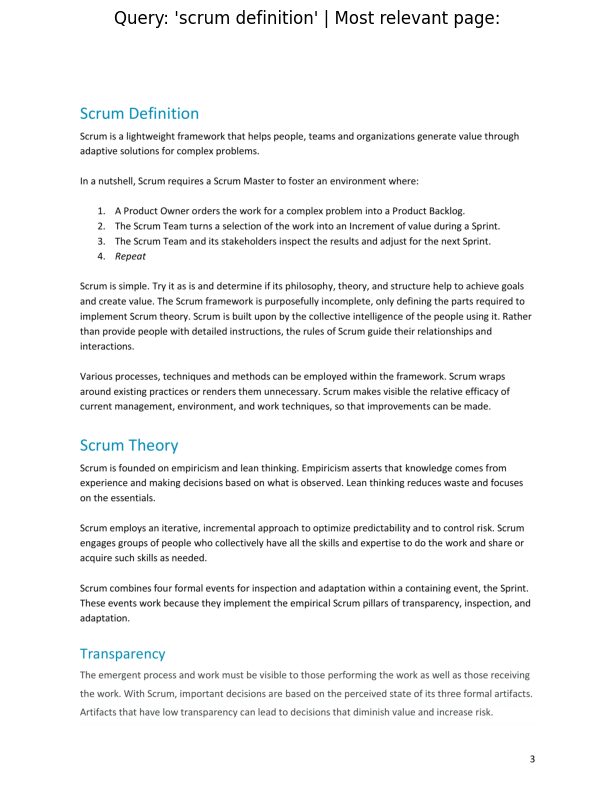

In [ ]:
import fitz

# Open PDF and load target page
pdf_path = "ScrumGuides2020.pdf" # requires PDF to be downloaded
doc = fitz.open(pdf_path)
page = doc.load_page(3) # number of page (our doc starts page numbers on page 41)

# Get the image of the page
img = page.get_pixmap(dpi=300)

# Optional: save the image
#img.save("output_filename.png")
doc.close()

# Convert the Pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv,
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

# Display the image using Matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis('off') # Turn off axis
plt.show()


That's the **retrieval** part of Retrieval Augmented Generation (RAG).


### Similarity measures: dot product and cosine similarity

Let's talk similarity measures between vectors.


Two of the most common you'll across are the dot product and cosine similarity.

They are quite similar.

The main difference is that cosine similarity has a normalization step.

| Similarity measure | Description | Code |
| ----- | ----- | ----- |
| [Dot Product](https://en.wikipedia.org/wiki/Dot_product) | - Measure of magnitude and direction between two vectors<br>- Vectors that are aligned in direction and magnitude have a higher positive value<br>- Vectors that are opposite in direction and magnitude have a higher negative value | [`torch.dot`](https://pytorch.org/docs/stable/generated/torch.dot.html), [`np.dot`](https://numpy.org/doc/stable/reference/generated/numpy.dot.html), [`sentence_transformers.util.dot_score`](https://www.sbert.net/docs/package_reference/util.html#sentence_transformers.util.dot_score) |
| [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) | - Vectors get normalized by magnitude/[Euclidean norm](https://en.wikipedia.org/wiki/Norm_(mathematics))/L2 norm so they have unit length and are compared more so on direction<br>- Vectors that are aligned in direction have a value close to 1<br>- Vectors that are opposite in direction have a value close to -1 | [`torch.nn.functional.cosine_similarity`](https://pytorch.org/docs/stable/generated/torch.nn.functional.cosine_similarity.html), [`1 - scipy.spatial.distance.cosine`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cosine.html) (subtract the distance from 1 for similarity measure), [`sentence_transformers.util.cos_sim`](https://www.sbert.net/docs/package_reference/util.html#sentence_transformers.util.cos_sim) |

For text similarity, you generally want to use cosine similarity as you are after the semantic measurements (direction) rather than magnitude.

In our case, our embedding model `all-mpnet-base-v2` outputs normalized outputs (see the [Hugging Face model card](https://huggingface.co/sentence-transformers/all-mpnet-base-v2#usage-huggingface-transformers) for more on this) so dot product and cosine similarity return the same results. However, dot product is faster due to not need to perform a normalize step.

To make things bit more concrete, let's make simple dot product and cosine similarity functions and view their results on different vectors.


In [ ]:
import torch

def dot_product(vector1, vector2):
    return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
    dot_product = torch.dot(vector1, vector2)

    # Get Euclidean/L2 norm of each vector (removes the magnitude, keeps direction)
    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))

    return dot_product / (norm_vector1 * norm_vector2)

# Example tensors
vector1 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector2 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector3 = torch.tensor([4, 5, 6], dtype=torch.float32)
vector4 = torch.tensor([-1, -2, -3], dtype=torch.float32)

# Calculate dot product
print("Dot product between vector1 and vector2:", dot_product(vector1, vector2))
print("Dot product between vector1 and vector3:", dot_product(vector1, vector3))
print("Dot product between vector1 and vector4:", dot_product(vector1, vector4))

# Calculate cosine similarity
print("Cosine similarity between vector1 and vector2:", cosine_similarity(vector1, vector2))
print("Cosine similarity between vector1 and vector3:", cosine_similarity(vector1, vector3))
print("Cosine similarity between vector1 and vector4:", cosine_similarity(vector1, vector4))

Dot product between vector1 and vector2: tensor(14.)
Dot product between vector1 and vector3: tensor(32.)
Dot product between vector1 and vector4: tensor(-14.)
Cosine similarity between vector1 and vector2: tensor(1.0000)
Cosine similarity between vector1 and vector3: tensor(0.9746)
Cosine similarity between vector1 and vector4: tensor(-1.0000)


Notice for both dot product and cosine similarity the comparisons of `vector1` and `vector2` are the opposite of `vector1` and `vector4`.

Comparing `vector1` and `vector2` both equations return positive values (14 for dot product and 1.0 for cosine similarity).

But comparing `vector1` and `vector4` the result is in the negative direction.

This makes sense because `vector4` is the negative version of `vector1`.

For the dot product, the value is positive and larger then the comparison of two exactly the same vectors (32 vs 14).

However, for the cosine similarity, thanks to the normalization step, comparing `vector1` and `vector3` results in a postive value close to 1 but not exactly 1.

It is because of this that when comparing text embeddings, cosine similarity is generally favoured as it measures the difference in direction of a pair of vectors rather than difference in magnitude.

And it is this difference in direction that is more generally considered to capture the semantic meaning of the text.

The outputs of our embedding model `all-mpnet-base-v2` are already normalized.

So we can continue using the dot product (cosine similarity is dot product + normalization).



### Functionizing our semantic search pipeline

Let's put all of the steps from above for semantic search into a function or two so we can repeat the workflow.

In [ ]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """

    # Embed the query
    query_embedding = model.encode(query,
                                   convert_to_tensor=True)

    # Get dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores,
                                 k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Takes a query, retrieves most relevant resources and prints them out in descending order.

    Note: Requires pages_and_chunks to be formatted in a specific way (see above for reference).
    """

    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)

    print(f"Query: {query}\n")
    print("Results:")
    # Loop through zipped together scores and indicies
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        # Print the page number too so we can reference the textbook further and check the results
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")

Excellent! Now let's test our functions out.

In [ ]:
query = "the definition of done"

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

[INFO] Time taken to get scores on 29 embeddings: 0.00196 seconds.


(tensor([0.5224, 0.5102, 0.2412, 0.2001, 0.1520], device='cuda:0'),
 tensor([26, 25, 16, 24,  3], device='cuda:0'))

In [ ]:
# Print out the texts of the top scores
print_top_results_and_scores(query=query,
                             embeddings=embeddings)

[INFO] Time taken to get scores on 29 embeddings: 0.00010 seconds.
Query: the definition of done

Results:
Score: 0.5224
If the Definition of Done for an increment is part of the standards of the
organization, all Scrum Teams must follow it as a minimum. If it is not an
organizational standard, the Scrum Team must create a Definition of Done
appropriate for the product.  The Developers are required to conform to the
Definition of Done. If there are multiple Scrum Teams working together on a
product, they must mutually define and comply with the same Definition of Done.
Page number: 9


Score: 0.5102
12  Multiple Increments may be created within a Sprint. The sum of the
Increments is presented at the Sprint Review thus supporting empiricism.
However, an Increment may be delivered to stakeholders prior to the end of the
Sprint. The Sprint Review should never be considered a gate to releasing value.
Work cannot be considered part of an Increment unless it meets the Definition of
Done. Com

### Semantic search/vector search extensions

We've covered an exmaple of using embedding vector search to find relevant results based on a query.

However, you could also add to this pipeline with traditional keyword search.

Many modern search systems use keyword and vector search.




### Getting an LLM

We're got our retrieval pipeline ready, let's now get the generation side of things happening.

To perform generation, we're going to use a Large Language Model (LLM).


### Loading an LLM locally

Alright! Looks like `gemma-2b-it` it is `use_quantization_config` values to suit your needs)!


In [ ]:
from huggingface_hub import HfApi, HfFolder, notebook_login

# Log in to Hugging Face (you might want to use `notebook_login()` if you're in a Jupyter notebook)
notebook_login()

# Instantiate the Hugging Face API
api = HfApi()

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available

# 1. Create quantization config for smaller model loading (optional)
# Requires !pip install bitsandbytes accelerate, see: https://github.com/TimDettmers/bitsandbytes, https://huggingface.co/docs/accelerate/
# For models that require 4-bit quantization (use this if you have low GPU memory available)
from transformers import BitsAndBytesConfig
use_quantization_config = True
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16)

# Bonus: Setup Flash Attention 2 for faster inference, default to "sdpa" or "scaled dot product attention" if it's not available
# Flash Attention 2 requires NVIDIA GPU compute capability of 8.0 or above, see: https://developer.nvidia.com/cuda-gpus
# Requires !pip install flash-attn, see: https://github.com/Dao-AILab/flash-attention

attn_implementation = "sdpa"
print(f"[INFO] Using attention implementation: {attn_implementation}")

# 2. Pick a model we'd like to use (this will depend on how much GPU memory you have available)
model_id = "google/gemma-2b-it"
print(f"[INFO] Using model_id: {model_id}")

# 3. Instantiate tokenizer (tokenizer turns text into numbers ready for the model)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

# 4. Instantiate the model
llm_model = AutoModelForCausalLM.from_pretrained(model_id,
                                                 torch_dtype=torch.bfloat16, # datatype to use, we want float16
                                                 low_cpu_mem_usage=False, # use full memory
                                                 attn_implementation=attn_implementation) # which attention version to use

llm_model.to("cuda")

[INFO] Using attention implementation: sdpa
[INFO] Using model_id: google/gemma-2b-it


Gemma's activation function should be approximate GeLU and not exact GeLU.
Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu`, edit the `model.config` to set `hidden_activation=gelu`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
    (norm): GemmaR

We've got an LLM!

Let's check it out.

In [ ]:
llm_model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
    (norm): GemmaR

In [ ]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

2506172416

### Generating text with our LLM

We can generate text with our LLM `model` instance by calling the [`generate()` method](https://huggingface.co/docs/transformers/v4.38.2/en/main_classes/text_generation#transformers.GenerationConfig) (this method has plenty of options to pass into it alongside the text) on it and passing it a tokenized input.

The tokenized input comes from passing a string of text to our `tokenizer`.

It's important to note that you should use a tokenizer that has been paired with a model.

O

In [ ]:
input_text = "Definition of Done"
print(f"Input text:\n{input_text}")
# Create prompt template for instruction-tuned model
dialogue_template = [
    {"role": "user",
     "content": input_text}
]

# Apply the chat template
prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False, # keep as raw text (not tokenized)
                                       add_generation_prompt=True)
print(f"\nPrompt (formatted):\n{prompt}")


Input text:
Definition of Done

Prompt (formatted):
<bos><start_of_turn>user
Definition of Done<end_of_turn>
<start_of_turn>model



Notice the scaffolding around our input text, this is the kind of turn-by-turn instruction tuning our model has gone through.

Our next step is to tokenize this formatted text and pass it to our model's `generate()` method.




In [ ]:
%%time

# Tokenize the input text (turn it into numbers) and send it to GPU
input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
print(f"Model input (tokenized):\n{input_ids}\n")

# Generate outputs passed on the tokenized input
outputs = llm_model.generate(**input_ids,
                             max_new_tokens=256) # define the maximum number of new tokens to create
print(f"Model output (tokens):\n{outputs[0]}\n")

Model input (tokenized):
{'input_ids': tensor([[    2,     2,   106,  1645,   108, 15085,   576, 34575,   107,   108,
           106,  2516,   108]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

Model output (tokens):
tensor([     2,      2,    106,   1645,    108,  15085,    576,  34575,    107,
           108,    106,   2516,    108,    688,  18185,    688,    603,    476,
          2329,    689,   4913,    674,  89450,    573,  17230,    576,    476,
          6911,    689,   3542, 235265,   1165,  14939,    674,    573,   1160,
           603,   9351,    578,    573,  17526,    919,   1125,  14645, 235265,
           109,    688,  51753,    576,  34575,  66058,    109, 235287,   5231,
         52928,  66058,    714,   6911,    603,   7382,   8735,    578,    573,
         13142,  17526,    919,   1125,   8951, 235265,    108, 235287,   5231,
         11263,    684,  66058,    714,   1160,    603,   3407,    578,   2952,
  

In [ ]:
# Decode the output tokens to text
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}\n")

Model output (decoded):
<bos><bos><start_of_turn>user
Definition of Done<end_of_turn>
<start_of_turn>model
**Done** is a state or condition that signifies the completion of a task or project. It indicates that the work is finished and the outcome has been achieved.

**Characteristics of Done:**

* **Completion:** The task is fully completed and the desired outcome has been reached.
* **Finality:** The work is complete and cannot be undone.
* **Closure:** The task is considered final and cannot be restarted or continued.
* **Satisfaction:** The task has been successfully completed to the satisfaction of the individual or organization.

**Examples of Done:**

* A project is considered done when all tasks are completed and the final report is submitted.
* A software release is considered done when the software is fully tested and released to users.
* A legal case is considered done when a verdict is reached and the case is closed.

**Note:**

The definition of done can vary depending on t

`"<bos>"` and `"<eos>"` are special tokens to denote "beginning of sentence" and "end of sentence" respectively.

In [ ]:
print(f"Input text: {input_text}\n")
print(f"Output text:\n{outputs_decoded.replace(prompt, '').replace('<bos>', '').replace('<eos>', '')}")

Input text: Definition of Done

Output text:
**Done** is a state or condition that signifies the completion of a task or project. It indicates that the work is finished and the outcome has been achieved.

**Characteristics of Done:**

* **Completion:** The task is fully completed and the desired outcome has been reached.
* **Finality:** The work is complete and cannot be undone.
* **Closure:** The task is considered final and cannot be restarted or continued.
* **Satisfaction:** The task has been successfully completed to the satisfaction of the individual or organization.

**Examples of Done:**

* A project is considered done when all tasks are completed and the final report is submitted.
* A software release is considered done when the software is fully tested and released to users.
* A legal case is considered done when a verdict is reached and the case is closed.

**Note:**

The definition of done can vary depending on the context and the specific task or project. However, the core

In [ ]:

query = "Definition of Done",




And now let's check if our `retrieve_relevant_resources()` function works with our list of queries.

In [ ]:
print(f"Query: {query}")

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

Query: ('the definition of done ?',)
[INFO] Time taken to get scores on 29 embeddings: 0.00007 seconds.


(tensor([0.5473, 0.5229, 0.2676, 0.2555, 0.2190], device='cuda:0'),
 tensor([25, 26, 16, 24,  3], device='cuda:0'))

### Augmenting our prompt with context items

What we'd like to do with augmentation is take the results from our search for relevant resources and put them into the prompt that we pass to our LLM.

In essence, we start with a base prompt and update it with context text.

Let's write a function called `prompt_formatter` that takes in a query and our list of context items (in our case it'll be select indices from our list of dictionaries inside `pages_and_chunks`) and then formats the query with text from the context items.

We'll apply the dialogue and chat template to our prompt before returning it as well.

> **Note:** The process of augmenting or changing a prompt to an LLM is known as prompt engineering. And the best way to do it is an active area of research. For a comprehensive guide on different prompt engineering techniques, I'd recommend the Prompt Engineering Guide ([promptingguide.ai](https://www.promptingguide.ai/)), [Brex's Prompt Engineering Guide](https://github.com/brexhq/prompt-engineering) and the paper [Prompt Design and Engineering: Introduction and Advanced Models](https://arxiv.org/abs/2401.14423).

In [ ]:
def prompt_formatter(query: str,
                     context_items: list[dict]) -> str:
    """
    Augments query with text-based context from context_items.
    """
    # Join context items into one dotted paragraph
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

    # Create a base prompt with examples to help the model
    # Note: this is very customizable, I've chosen to use 3 examples of the answer style we'd like.
    # We could also write this in a txt file and import it in if we wanted.
    base_prompt = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.
\nExample 1:
Query: What is Scrum?
Answer: Scrum is a framework for agile project management that helps teams deliver high-value products iteratively. It emphasizes flexibility, collaboration, and continuous improvement. In Scrum, work is organized into time-boxed iterations called sprints, typically lasting 2-4 weeks. The Scrum framework includes roles such as Scrum Master, Product Owner, and Development Team, each with specific responsibilities. Daily stand-up meetings, sprint planning, sprint review, and sprint retrospective are key Scrum events that facilitate transparency, inspection, and adaptation.
\nExample 2:
Query: What are the roles in Scrum?
Answer: Scrum defines three primary roles: Scrum Master, Product Owner, and Development Team. The Scrum Master is responsible for facilitating the Scrum process, removing impediments, and ensuring that the team adheres to Scrum principles and practices. The Product Owner represents the stakeholders and is responsible for maximizing the value of the product by managing the product backlog and prioritizing work. The Development Team is a cross-functional group responsible for delivering the increments of the product during each sprint.
\nExample 3:
Query: What are the benefits of using Scrum?
Answer: Scrum offers several benefits for teams and organizations. It promotes transparency, as progress is visible through regular meetings and artifacts like the product backlog and burndown charts. Collaboration is enhanced, as teams work closely together and communicate frequently. Scrum enables faster delivery of valuable product increments, allowing teams to respond quickly to changing requirements and market conditions. It also fosters a culture of continuous improvement, with regular opportunities for reflection and adaptation.
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""


    # Update base prompt with context items and query
    base_prompt = base_prompt.format(context=context, query=query)

    # Create prompt template for instruction-tuned model
    dialogue_template = [
        {"role": "user",
        "content": base_prompt}
    ]

    # Apply the chat template
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                          tokenize=False,
                                          add_generation_prompt=True)
    return prompt

In [ ]:

print(f"Query: {query}")

# Get relevant resources
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)

# Create a list of context items
context_items = [pages_and_chunks[i] for i in indices]

# Format prompt with context items
prompt = prompt_formatter(query=query,
                          context_items=context_items)
print(prompt)

Query: ('Definition of Done',)
[INFO] Time taken to get scores on 29 embeddings: 0.00007 seconds.
<bos><start_of_turn>user
Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.

Example 1:
Query: What is Scrum?
Answer: Scrum is a framework for agile project management that helps teams deliver high-value products iteratively. It emphasizes flexibility, collaboration, and continuous improvement. In Scrum, work is organized into time-boxed iterations called sprints, typically lasting 2-4 weeks. The Scrum framework includes roles such as Scrum Master, Product Owner, and Development Team, each with specific responsibilities. Daily stand-up meetings, sprint planning, sprint review, and sprint retrospective ar

In [ ]:
%%time

input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

# Generate an output of tokens
outputs = llm_model.generate(**input_ids,
                             temperature=0.9, # lower temperature = more deterministic outputs, higher temperature = more creative outputs
                             do_sample=True, # whether or not to use sampling, see https://huyenchip.com/2024/01/16/sampling.html for more
                             max_new_tokens=256) # how many new tokens to generate from prompt

# Turn the output tokens into text
output_text = tokenizer.decode(outputs[0])

print(f"Query: {query}")
print(f"RAG answer:\n{output_text.replace(prompt, '')}")

Query: ('Definition of Done',)
RAG answer:
<bos>According to the context, the Definition of Done for an increment is a formal description of the state of the Increment when it meets the quality measures required for the product. It is a comprehensive document that outlines the requirements for an increment, including its scope, acceptance criteria, and testing procedures. The Definition of Done must be established by the Product Owner and agreed upon by the entire Scrum Team.<eos>
CPU times: user 4.97 s, sys: 85.8 ms, total: 5.05 s
Wall time: 6.79 s


In [ ]:
def ask(query,
        temperature=0.9,
        max_new_tokens=512,
        format_answer_text=True,
        return_answer_only=True):
    """
    Takes a query, finds relevant resources/context and generates an answer to the query based on the relevant resources.
    """

    # Get just the scores and indices of top related results
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings)

    # Create a list of context items
    context_items = [pages_and_chunks[i] for i in indices]

    # Add score to context item
    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu() # return score back to CPU

    # Format the prompt with context items
    prompt = prompt_formatter(query=query,
                              context_items=context_items)

    # Tokenize the prompt
    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

    # Generate an output of tokens
    outputs = llm_model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)

    # Turn the output tokens into text
    output_text = tokenizer.decode(outputs[0])

    if format_answer_text:
        # Replace special tokens and unnecessary help message
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "").replace("Sure, here is the answer to the user query:\n\n", "")

    # Only return the answer without the context items
    if return_answer_only:
        return output_text

    return output_text, context_items

In [ ]:
print(f"Query: {query}")

# Answer query with context and return context
answer, context_items = ask(query=query,
                            temperature=0.7,
                            max_new_tokens=512,
                            return_answer_only=False)

print(f"Answer:\n")
print_wrapped(answer)
print(f"Context items:")
context_items

Query: ('Definition of Done',)
[INFO] Time taken to get scores on 29 embeddings: 0.00007 seconds.
Answer:

Sure, here's the answer to the user query:  According to the context, the
definition of "Definition of Done" is a formal description of the state of an
Increment when it meets the quality measures required for the product. It should
be a clear and concise document that provides everyone on the team, including
the Product Owner and the Development Team, with a shared understanding of what
work was completed as part of the Increment.
Context items:


[{'page_number': 9,
  'sentence_chunk': 'If the Definition of Done for an increment is part of the standards of the organization, all Scrum Teams must follow it as a minimum. If it is not an organizational standard, the Scrum Team must create a Definition of Done appropriate for the product.  The Developers are required to conform to the Definition of Done. If there are multiple Scrum Teams working together on a product, they must mutually define and comply with the same Definition of Done.',
  'chunk_char_count': 454,
  'chunk_word_count': 80,
  'chunk_token_count': 113.5,
  'embedding': array([-3.44686396e-02,  2.42460780e-02,  1.50863007e-02, -9.15650129e-02,
         -9.92561597e-03, -1.24947019e-02,  7.56662339e-03, -1.02236860e-01,
         -7.79113248e-02,  1.22447498e-04,  8.08636695e-02,  1.37256021e-02,
          4.16460969e-02,  5.84581383e-02, -4.00252752e-02,  3.92198861e-02,
          4.67942096e-02,  9.98468883e-03, -4.67440039e-02,  4.64752242e-02,
         -5.04227020e